In [1]:
import os
import cv2
import re
import pandas as pd
import numpy as np

D:\Download2\Anaconda\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Download2\Anaconda\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
D:\Download2\Anaconda\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
from matplotlib import pyplot as plt

In [3]:
from imutils.object_detection import non_max_suppression

In [20]:
pd.set_option('display.max_columns', 500)

In [5]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [3]:
textmatch = pd.read_csv('textmatch.csv')
facematch = pd.read_csv('facematch.csv')

In [17]:
ids=  textmatch[textmatch['subclass']==1997]['App_Id'].to_list()

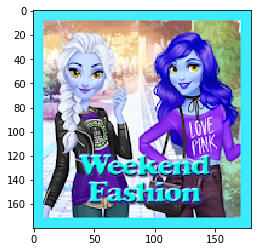

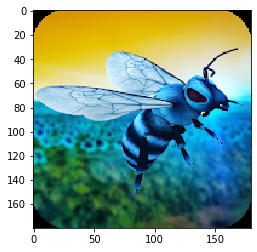

In [19]:
for i in ids:
        name = i+'.jpg'
        image = cv2.imread(os.path.join('./CrawlingData/images/', name))
        plt.imshow(image)
        plt.show()

In [93]:
args = {"min_confidence":0.7, "width":320, "height":320}
# Returns a bounding box and probability score if it is more than minimum confidence
def predictions(prob_score, geo):
	(numR, numC) = prob_score.shape[2:4]
	boxes = []
	confidence_val = []

	# loop over rows
	for y in range(0, numR):
		scoresData = prob_score[0, 0, y]
		x0 = geo[0, 0, y]
		x1 = geo[0, 1, y]
		x2 = geo[0, 2, y]
		x3 = geo[0, 3, y]
		anglesData = geo[0, 4, y]

		# loop over the number of columns
		for i in range(0, numC):
			if scoresData[i] < args["min_confidence"]:
				continue

			(offX, offY) = (i * 4.0, y * 4.0)

			# extracting the rotation angle for the prediction and computing the sine and cosine
			angle = anglesData[i]
			cos = np.cos(angle)
			sin = np.sin(angle)

			# using the geo volume to get the dimensions of the bounding box
			h = x0[i] + x2[i]
			w = x1[i] + x3[i]

			# compute start and end for the text pred bbox
			endX = int(offX + (cos * x1[i]) + (sin * x2[i]))
			endY = int(offY - (sin * x1[i]) + (cos * x2[i]))
			startX = int(endX - w)
			startY = int(endY - h)

			boxes.append((startX, startY, endX, endY))
			confidence_val.append(scoresData[i])

	# return bounding boxes and associated confidence_val
	return (boxes, confidence_val)


def text_recognition(image,configuration):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    b = np.concatenate((gray[0,:],gray[:,0]))
    bg =   np.mean(b)
#     bg2 = gray[0,0],gray[-1,-1]
    thresh = cv2.GaussianBlur(gray, (1,1), 0)
    bg1 = gray[0,0]
    if bg1 >240:
            thresh = cv2.threshold(thresh, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    else:
           thresh = cv2.threshold(thresh, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    kernel = np.ones((1,1),np.uint8)
    opening  = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)     

    text = pytesseract.image_to_string(opening, config=configuration)
    plt.imshow(opening,cmap='Greys_r')
    plt.show()
    return text

net = cv2.dnn.readNet('frozen_east_text_detection.pb')

# The following two layer need to pulled from EAST model for achieving this. 
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

In [94]:
#names = randoms['App Id'].to_list()
names= ['com.bestappsbox.hoppingbird']

0


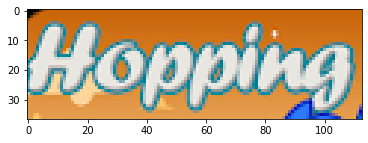

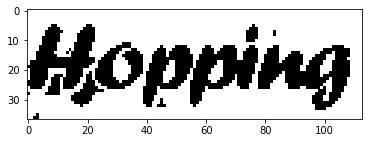

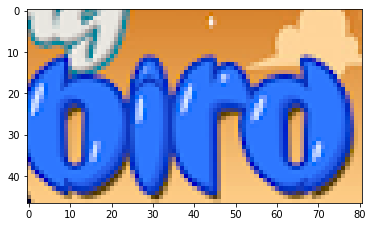

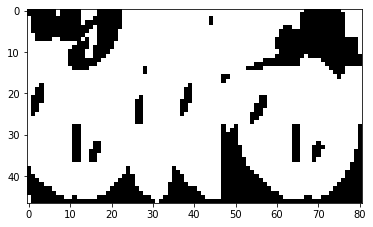

In [95]:
texts = []
for i,appname in enumerate(names):
        cur = []
        if i%100 == 0:
            print(i)
        part = appname+'.jpg'
        image = cv2.imread(os.path.join('./CrawlingData/images/', part))
        #Saving a original image and shape
        orig = image.copy()
#         plt.imshow(orig)
#         plt.show()
        (origH, origW) = image.shape[:2]
        # set the new height and width to default 320 by using args #dictionary.  
        (newW, newH) = (320,320)

        #Calculate the ratio between original and new image for both height and weight. 
        #This ratio will be used to translate bounding box location on the original image. 
        rW = origW / float(newW)
        rH = origH / float(newH)

        # resize the original image to new dimensions
        image = cv2.resize(image, (newW, newH))
        #grayimg = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        (H, W) = image.shape[:2]

        # construct a blob from the image to forward pass it to EAST model
        blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),(123.68, 116.78, 103.94), swapRB=True, crop=False)

        #Forward pass the blob from the image to get the desired output layers
        net.setInput(blob)
        (scores, geometry) = net.forward(layerNames)
        (boxes, confidence_val) = predictions(scores, geometry)
        
        boxes = non_max_suppression(np.array(boxes), probs=confidence_val)
        results=[]

        # loop over the bounding boxes to find the coordinate of bounding boxes
        for (startX, startY, endX, endY) in boxes:
        # scale the coordinates based on the respective ratios in order to reflect bounding box on the original image
                startX = int(startX * rW) -1
                startY = int(startY * rH) -1
                endX = int(endX * rW) +3
                endY = int(endY * rH) + 3

                if startX < 0:
                        startX = 0
                if startY < 0:
                        startY = 0
                if endX > orig.shape[1]:
                        endX = orig.shape[1]
                if endY > orig.shape[0]:
                        endY = orig.shape[0]          
                
                if endY<=startY or endX<=startX:
                    continue
                #extract the region of interest
                r = orig[startY:endY,startX:endX]

                #configuration setting to convert image to string.  
                configuration = ("-l eng --oem 1 --psm 8 ")
                ##This will recognize the text from the image of bounding box
                plt.imshow(r)
                plt.show()
                text = text_recognition(r,configuration)
                text = re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\xff\n]', '', text)
                # append bbox coordinate and associated text to the list of results 
                results.append(((startX,startY,endX,endY),text))



In [74]:
app_texts = pd.concat([one,two,three,four,five],axis=0).reset_index(drop=True)

In [129]:
apps.to_csv('appdata_withtext.csv')

Drive

FARMING



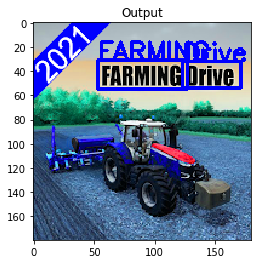

In [90]:
part = 'com.gvapps.quizriddles'+'.jpg'
image = cv2.imread(os.path.join('./CrawlingData/images/', part))
orig_image = orig.copy()

# Moving over the results and display on the image
for ((start_X, start_Y, end_X, end_Y), text) in results:
	# display the text detected by Tesseract
	print("{}\n".format(text))

	# Displaying text
	text = "".join([x if ord(x) < 128 else "" for x in text]).strip()
	cv2.rectangle(orig_image, (start_X, start_Y), (end_X, end_Y),
		(0, 0, 255), 2)
	cv2.putText(orig_image, text, (start_X, start_Y),
		cv2.FONT_HERSHEY_SIMPLEX, 0.7,(0,0, 255), 2)

plt.imshow(orig_image)
plt.title('Output')
plt.show()

In [34]:
results

[((0, 108, 180, 152), 'DASKENBAUA'), ((32, 84, 163, 126), 'PINBALE')]